# What do t-tests and their p-values mean?

One of the hardest, yet most important parts of math and science is statistics. And one of the most used (and mis-interpreted) parts of statistics is the t-test, which is often used to generate our well-known p-value. I have seen many different definitions for the p-value depending on the literature, like:

* The probability of rejecting the null hypothesys given that the null is true,
* The probability of observing an effect as extreme as the observed one given that initial assumptions are true,

and some variations of that. However, the underlying processes of t-tests and p-values are seldom understood.

In this post, I want to share my thoughts on **what do t-tests and their corresponding p-values really mean**, so that we can stop misinterpreting p-values or unintentionally doing p-value hacking.

It took me around two decades of academic life to come to terms with what that definition should be. It took me so long for many reasons: the mathematics behind the t-test are far from trivial, software packages nowadays are very easy to use, and p-values are simply widely accepted as basis for statements like "results were significantly improved from the baseline". I would be so happy if it didn't take you that long to realize some things that are more scary (because maths...) than actually complicated.

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# Central Limit Theorem: T-Test's older sibling

Our story here begin with the Central Limit Theorem (CLT). The scenario underlying the CLT is that we have samples of size $n$ which are drawn from an unknown distribution, and we want to understand more about the distribution. The CLT specifically refers to the relationship between $\mu$, which is the population mean for the distribution, and $\bar{X}$, which is the sample mean (which we measure!).

The CLT assumes that samples $X$ were drawn from a distribution with mean $\mu$ and variance $\sigma ^2$ (if you prefer: standard deviation $\sigma$). The original distribution that generated samples $X$ does not have to be normal or of any other specific shape. If our sample has $n$ elements, then we can calculate the sample mean $\bar{X}$ as:

$$
\bar{X} = \frac{\sum_{j=1}^n X_j}{n}
$$

We can expect the sample mean $\bar{X}$ to be close to the population mean $\mu$ (remember: $\mu$ comes from the distribution!). The CLT can help us understand how close these two quantities are! According to the CLT, $\bar{X}$ behaves as it were drawn from a normal distribution with mean $\mu$ and variance $\frac{\sigma ^2}{n}$, or:

$$
\bar{X} \sim N(\mu, \sigma^2/n)
$$

This equation means that samples with higher $n$ are likely to have a sample mean closer to the population mean.

But, how can we use this result?

# Using the Central Limt Theorem to reject a null hypothesis

Let's suppose that a bakery says their cupcakes weight, on average, 100g, with a standard deviation of 10g. This standard deviation accounts for the fact that cupcakes are made by hand. However, even handmade cupcakes have to follow food regulations rules, so we are hired to check if the cupcakes are following that specification. What do we do? We randomly select some cupcakes, creating a *sample*. Suppose we are running our test with $n=10$ cupcakes.

After some time in the laboratory, we find that our sample mean is 105g, which is within one standard deviation from the expected mean.

Now we ask ourselves: what are the chances that, if the specifications are followed, we observe a sample mean that is at least as high as the one we observed?

Because we know, from the CLT, that $\bar{X} \sim N(\mu, \sigma^2/n)$, we can calculate this probability using the cumulative distribution function of a normal, as in:

In [2]:
mu = 100
sigma = 10
n = 20
xbar = 105
sigma_xbar = sigma / np.sqrt(n)
p = 1-stats.norm.cdf(xbar, loc=mu, scale=sigma_xbar)
print(p)

0.0126736593387341


Now we have something to interpret:

* We observed $\bar{X}$.
* Bakery says their cupcakes' weights follow a specific distribution
* If what the bakery says is true, the probability of observing that specific $\bar{X}$ is around $\times 10^-2$

Something is odd here.

Either we screwed up the measurements, or the bakery is wrong about their cupcakes' weight distribution.

Because I am very skilled in weighting cupcakes, I will go with the latter: the weights likely do not have mean 100g and standard deviation 10g.

# Using a standard normal

We don't need to use a scale and translated version of the Normal distribution to calculate its values. Instead, we can scale and translate our measurements and then use a distribution $N(0,1)$ as a model. For such, we will need to calculate the standardized variable $Z$ as:

$$
Z = \frac{ \bar{X}-\mu}{\sigma / \sqrt{N}}
$$

Our code would now look like:


In [3]:
mu = 100
sigma = 10
n = 20
xbar = 105
sigma_xbar = sigma / np.sqrt(n)
Z = (xbar-mu)/sigma_xbar
p = 1-stats.norm.cdf(Z, loc=0, scale=1)
p_ = 1-stats.norm.cdf(xbar, loc=mu, scale=sigma_xbar) # Reference so everyone can see we are not crazy
print(Z, p, p_)

2.23606797749979 0.0126736593387341 0.0126736593387341


We have exactly the same results (which means math still works). But why should we do this? It feels much easier to use the `loc` and `scale` parameters!

It is fair to say that it is more intuitive to use Python's automatic shift and scale, because they keep us using real-world measurements: $\mu$ and $\bar{X}$ still represent "cupcake weight", that is, we can immediately interpret that.

However, the standardized variable $Z$ shows us information in a scale of deviations: a difference of $1$ in $Z$ means one standard deviation. This allows us to immediately evaluate if samples are too far away from expected values. In our cupcake case, this could have little added utility, but in multivariate cases it allows us to visualize which variables have a higher deviation from the mean.

In summary, the standardization leads to a closer dialogue with statistics theory, at the expense of losing the variable's original meaning. The standardization equation builds a bridge between these two worlds, and for this reason it is important to understand it.

In fact, Scipy uses the standardization in the "backend", using the `loc` and `scale` parameters provided by the user (that is, it shifts and scales the variables and then calculate statistics using the standard distributions).




# Null Hypothesis and the p-value

What happened here is that we had an initial hypothesis (the weights follow that specific distribution) and we gathered data that allowed us to state: if that is true, then there is a very small probability of observing our data. Consequently, we should reject - or nullify - this initial hypothesis. This is why this initial hypothesis is called *null hypothesis*.

Also, we have a probability of observing data at least as far from the initial hypothesis (or: at least as extreme) as the observed data. If this probability is very small, then we reject the null hypothesis. This is our $1 \times 10^-2$ probability calculated above. Because we don't want to say "the probability of observing data as extreme or more extreme than the data we actually observed" every time, we are going to call this a *p-value*.

# P-value: a pitfall when there are too many observations

Now, let's take a look at what happens when we change the number of observations:

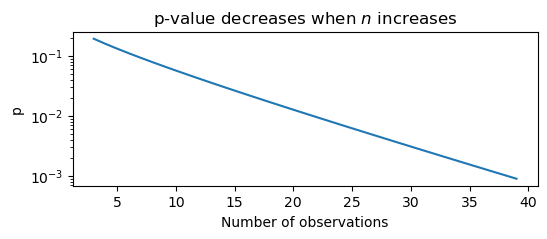

In [4]:
mu = 100
sigma = 10
n_ = range(3, 40)
xbar = 105
p_ = []
for n in n_:
    sigma_xbar = sigma / np.sqrt(n)
    p = 1-stats.norm.cdf(xbar, loc=mu, scale=sigma_xbar)
    p_.append(p)

plt.figure(figsize=(6,2))
plt.plot(n_, p_)
plt.xlabel("Number of observations")
plt.ylabel("p")
plt.title("p-value decreases when $n$ increases")
plt.semilogy()
plt.show()

Try to change values for `sigma` and `xbar`, and see that we find the same behavior.

When we have more observations in our sample, the p-value decreases. This is because the variance of the distribution of our sample mean is inversely proportional to the number of observations. Under this light, let's review our cupcake experiment.

We originally said: *because our p-value is very small, we reject the hypothesis that the cupcake weights follow some distribution with mean 100g and standard deviation 10g.*

The problem here is that we could have chosen any number of cupcakes to build our sample. And, as we observed above, with a large enough $n$, we can get a very small p-value regardless of the actual difference between the claimed population mean $\mu$ and the observed sample mean $\bar{X}$.

Actually, we could find a value of $n$ that allows us to get a p-value of $0.01$ even if our sample mean was just a negligible 0.1g above our claimed mean of 100g:


In [5]:
mu = 100
sigma = 10
xbar = 100.1
p = 1 # initial value
n = 3 # initial value
while p > 0.01:
    n = n+1
    sigma_xbar = sigma / np.sqrt(n)
    p = 1-stats.norm.cdf(xbar, loc=mu, scale=sigma_xbar)

print(n, p)

54119 0.009999968099338896


This is especially relevant when you are dealing with larger samples and big data, because samples can quickly reach this size. If the p-values are used naively, null hypotheses will be rejected and "outperforming the previous approach" will be claimed too often with a negligible effect. So, we might want to consider effect sizes as a further analysis. There is a whole theory on effect sizes, and I will probably get back to that in a future post, but if your field does not use any analysis of this sort then using the difference between the theoretical and the measured means (or: $|| \mu - \bar{X} ||$) might suffice.

For now, we will focus on a different case: when the population variance is unknown.

# The T-student distribution

The CLT, which is the base for all our deduction here, can only be used if we know the true population variance $\sigma^2$. This is usually not the case, as it is hard to find some situation is which we don't known the mean, but we know the variance of our population. If we don't know $\sigma^2$, we can estimate the sample variance $S^2$ and use it instead to standardize our input:

$$
T = \frac{ \bar{X}-\mu}{S / \sqrt{N}}
$$


Although $\bar{X}$, due to the CLT, follows a normal distribution, the sample variance $S^2$ is also a random variable. For this reason, $T$ does not follow a normal distribution. Instead, it follows a T-student distribution, which accounts for the uncertainty in $S$ by having longer tails.



The T-student distribution is similar to the normal regarding its simmetry, but is has greater values in the long tails. The T-student distribution depends on a parameter called *degrees of freedom* that corresponds, in our case, to the total number of samples minus the number of sample mean estimates in our experiment. For the cupcake scenario discussed above, we have one sample mean estimate.



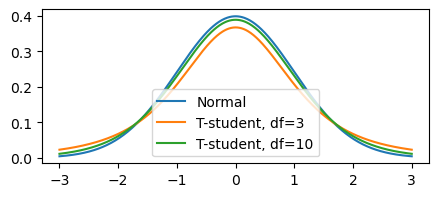

In [6]:
x = np.linspace(-3,3,500)
plt.figure(figsize=(5,2))
plt.plot(x, stats.norm.pdf(x), label='Normal')
plt.plot(x, stats.t.pdf(x, df=3), label='T-student, df=3')
plt.plot(x, stats.t.pdf(x, df=10), label='T-student, df=10')
plt.legend()
plt.show()

As we can see, the T-student distribution has longer tails than the normal, which account for its uncertainty. Also, when we increase the number of degrees of freedom, the T-Student distribution slowly converges to the normal.

# P-values using the T-Student distribution

Henceforth, if we didn't know $\sigma^2$ beforehand, we would calculate our p-value as:

In [7]:
n = 20
mu = 100
sigma = 10
sample_cupcakes = stats.norm.rvs(size=n, loc=105, scale=sigma, random_state=1)

sigma_est = np.std(sample_cupcakes, ddof=1)
xbar = np.mean(sample_cupcakes)

sigma_xbar = sigma_est / np.sqrt(n)
p = 1-stats.t.cdf(xbar, loc=mu, scale=sigma_xbar, df=n-1)
print(p)

0.08125674987566645


Note that now we don't use the "true" sigma in our calculations. Rather, even if we used it to generate samples, we used the sample standard deviation to proceed to our calculations.

# The one-sample t-test

What we just did is a one-sample t-test. We estimated our p-value using the cumulative distribution function of the t distribution, instead of the normal. This change was because the uncertainty in our sample variance estimator makes it necessary to use a t-student distribution.

Of course, because the one-sample t-test is performed many, many times, it comes bundled as part of our `scipy.stats` package:

In [8]:
stats.ttest_1samp(sample_cupcakes, popmean=mu, alternative='greater')

Ttest_1sampResult(statistic=1.4530992590921659, pvalue=0.08125674987566646)

We can already see that the p-value matches our estimation above, but what do each of these other parameters mean?

# P-Values using the T-Statistic

The Student-T distribution is mathematically as centered in zero, similarly to the standard normal distribution. Although the scipy implementation kindly allows us to shift and scale our inputs in the backend, using de `loc` and `scale` parameters, this could lead to the false impression that $\bar{X}$ follows a T distribution. It does not!!! Rather, the T statistic (that is, the standardization of $\bar{X} using the sample variance $S^2$) is the one that follows the T distribution. 

We can avoid this confusion by standardizing our samples ourselves to obtain the same results as above:

In [9]:
# What we did so far: use python's loc and scale parameters to
# implicitly standardize our input
p1 = 1-stats.t.cdf(xbar, loc=mu, scale=sigma_xbar, df=n-1)

# What is usually done: explicitly standardize our input
t_statistic = (xbar-mu) / sigma_xbar
p2 = 1-stats.t.cdf(t_statistic, df=n-1)

print(p1, t_statistic, p2)

0.08125674987566645 1.4530992590921659 0.08125674987566645


# The Alternative Hypothesis (and refinements to the Null Hypothesis)

In our function call, we had the parameter: `alternative='greater'`. The alternative hypothesis is the negation, or the complement, of the null hypothesis. In our cupcake scenario, we simply assumed that we wanted to calculate the probability that our sample mean is at least as high as the one we got.

However, it could be the case that we wanted the probability that the sample mean is at least as far from the population mean as we have. In this case, we would need to "reflect" $\bar{x}$ around $\mu$ and then calculate the area in both "tails". This is called a two-tailed test, and, because of the symmetry in the t-distribution, it gives a value twice as large as the one-tailed test:

In [10]:
p = 2 * (1-stats.t.cdf(xbar, loc=mu, scale=sigma_xbar, df=n-1))
print(p)
print(stats.ttest_1samp(sample_cupcakes, popmean=mu, alternative='two-sided'))

0.1625134997513329
Ttest_1sampResult(statistic=1.4530992590921659, pvalue=0.16251349975133292)


All right.

So far, we have a test for when we know the mean and variance of the population. We also have the t-test for when we know the mean, but not the variance of the population. But, in real life, we often simply have two groups - say, group A and group B - being measured, and we have no hypothesys on their means or variances. This gives rise to...

# The two-sample t-test

Although we could leave the cupcakes behind, this would make me so sad. In this example, we are going to use two bakeries (A and B), and all we have are some cupcake samples from each one of them. Can we safely say that their cupcakes' weights, on average, are not the same?

For this, let's start by generating some samples for each bakery, and calculate sample statistics for each one:

In [46]:
nA = 10
nB = 10
samplesA = stats.norm.rvs(size=nA, loc=90, scale=10)
samplesB = stats.norm.rvs(size=nB, loc=100, scale=10)

xbarA = np.mean(samplesA)
xbarB = np.mean(samplesB)
sigmaA = np.std(samplesA, ddof=1)/np.sqrt(nA)
sigmaB = np.std(samplesB, ddof=1)/np.sqrt(nB)

Although we don't know the real means of the distributions, we know that, if they have the same means, then the mean of their differences should be zero. Remeber that when we subtract two independent random variables we obtain a third random variable whose mean is the subtraction of the original means, and whose variance is the **sum** of the original variances!

Hence, what we are going to do is:
1. Assume there is no difference between the means of the samples,
2. Estimate values for the mean and standard deviation of C=A-B,
3. Calculate the probability of finding a difference as large as we have found assuming that the mean of C ($\mu_c$) is zero


In [50]:
xbarC = xbarA-xbarB
sigmaC = np.sqrt( (sigmaA**2) + (sigmaB**2) )
#print(sigmaA, sigmaB, sigmaC)

t = xbarC/sigmaC
p = stats.t.cdf(t, df=nA+nB-2)*2
print(t, p)

-1.0676048932502877 0.29980876583804517


Note that we now have `nA+nB-2` degrees of freedom in the t distribution. This is a special case of the estimation of degrees of freedom using the [Welch-Satterthwaite equation](https://en.wikipedia.org/wiki/Welch%E2%80%93Satterthwaite_equation) when $nA=nB$. This is a more complicated issue and I plan on devoting another blog post to discuss degrees of freedom.

Like the one-sample T-Test, there is also a ready-made function for the two-sample T-Test:

In [48]:
stats.ttest_ind(samplesA, samplesB) # Did I just read a whole blog post only to copy this one line!??

Ttest_indResult(statistic=-1.0676048932502877, pvalue=0.29980876583804517)

And, if you know the sample means and standard deviations, you can use `ttest_ind_from_stats`, which yields the same value:

In [49]:
stats.ttest_ind_from_stats(mean1=xbarA, mean2=xbarB, std1=np.std(samplesA, ddof=1), std2=np.std(samplesB, ddof=1), nobs1=len(samplesA), nobs2=len(samplesB)) # Did I just read a whole blog post only to copy this one line!??

Ttest_indResult(statistic=-1.0676048932502877, pvalue=0.29980876583804517)

We could also scale our student-t distribution instead of our mean, and get the same result:

In [51]:
xbarC = xbarA-xbarB
sigmaC = np.sqrt( (sigmaA**2) + (sigmaB**2) )

# Use the t-statistic means shifting and scaling the samples
t = xbarC/sigmaC
p = stats.t.cdf(t, df=nA+nB-2)*2
print(t, p)

# Or, we could shift and scale the distribution:
p = stats.t.cdf(xbarA, loc=xbarB, scale=sigmaC, df=nA+nB-2)*2
print(p)

-1.0676048932502877 0.29980876583804517
0.29980876583804517


# Next steps

We have investigated p-values in the context of t-tests. The p-values using t-tests rely on the assumption that the mean of our samples are random variables drawn from a normal distribution. This assumption is strong and frequently holds because it is a decorrence of the Central Limit Theorem. On top of the CLT, add a correction to the uncertainty regarding the sample variance, which leads to the Student-T distribution for the standardized T statistic calculated from the sample mean.

This is a mathematically sound theory, and it delivers what is promised: we can estimate the probability of generating a sample mean at least as different from a reference value. A low probability indicates that the reference is inadequate.

However, simply relying on p-values to make decisions can be tricky. As we have seen, increasing $n$ deliberately can lead to finding low $p$ values, regardless of the difference between the means we are evaluating. This is not a failure of the p-value or the t-tests: they are doing exactly what they are supposed to, which is calculating the **probability of observing our data or a more disfavorable outcome under the assumption that the null hypothesis is true**.

Even if we have a very low p-value, we reject the null hypothesis and *so what*? Would a negligible difference between cupcake weights be meaningful in real life?

Also, can we estimate "how negligible" is the observed difference between means?

This is something to discuss in another post.